численное решение уравнения диффузии

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

import scipy as scipy

#from tqdm import tqdm_notebook
import time

from tqdm import tqdm

In [72]:
class Diffusion:
    # сетки
    def __init__(self):
        return
        
    def solve(self, D):
        L = 1
        Nx = 11
        self.Nx = Nx
        Nt = 101
        self.Nt = Nt
        T_end = 100
        dx = L/(Nx-1)
        self.dx = dx
        dt =T_end/(Nt-1)
        self.x = np.linspace(0,L,Nx)
        
        left_cond = 1 # слева concentration
        right_cond = -1 # справа значение концентрации
        CTR_0 = -10

        CTR = np.zeros((Nx, Nt))
        try:
            ll = np.shape(D)
            if ll[0] == Nx and ll[1] == Nt:
                pass
            else:
                D = self.get_D(D)
        except IndexError:
            D = self.get_D(D)
        
        # boundaries
        CTR[:,0] = CTR_0

        CTR[0,:] = left_cond
        CTR[Nx-1,0] = right_cond
        
        
      
        
        A = np.zeros((Nx,Nx,Nt))
        b = np.zeros((Nx,Nt))
        b1 = np.zeros((Nx,Nx,Nt))
        
        dd = (dx*dx) / dt
        
        
        for j in range(Nt-1):
        
            A[0,0,j] = 1
            A[Nx-1,Nx-1,j] = 1
            b[0,j] = CTR[0,j]
            b[Nx-1,j] = CTR[Nx-1,j]
            b1[0,0,j] = 1
            b1[Nx-1,Nx-1,j] = 1
            
            for i in range(1,Nx-1):
                A[i,i,j] = - (D[i,j] + D[i+1,j] + dd)
                A[i,i+1,j] = D[i+1,j]
                b[i,j] = - dd * CTR[i,j]
                b1[i,i,j] = - dd
            for i in range(0,Nx-2):
                A[i+1,i,j] = D[i,j]
            
            CTR[:,j+1] = np.linalg.solve(A[:,:,j], b[:,j])
            
    
        
        self.solution = CTR
        return CTR, A, b, b1, D
    
    def cf_grad(self, D, tstep):
        Nx = self.Nx
        Nt = self.Nt
        C_fix = self.C_fix
        

        Lun = np.zeros((Nx,Nt))
        lam = np.zeros((Nx,Nt))
        CTR, A, b, b1, D = self.solve(D) 
        

        
        lam[:,Nt-1] = -(CTR[:,Nt-1] - C_fix[:,Nt-1]) @ np.linalg.inv(A[:,:,Nt-2])
        
        
        for j in range(Nt-2,0,-1):
            lam[:,j] = - ((CTR[:,j] - C_fix[:,j]) + lam[:,j+1] @ (b1[:,:,j])) @ np.linalg.inv(A[:,:,j-1])

        
        gu = np.zeros((Nx,Nx,Nt))
        
        for j in range(Nt-1):
            gu[0,0,j] = - CTR[0,j+1]
            gu[Nx-1,Nx-1,j] = -CTR[Nx-1,j+1]
            for i in range(1,Nx-1):
                gu[i,i,j] = CTR[i-1,j+1] - CTR[i,j+1]
                gu[i,i+1,j] = CTR[i+1,j+1] - CTR[i,j+1]
        
                
        grad = np.zeros((Nx, Nt))
        for j in range(Nt):
            grad[:,j] = lam[:,j] @ gu[:,:,j]
        
        grad = grad / np.linalg.norm(grad)
        
        return grad[:,tstep]
            
            
    
    def cost_function(self, D, tstep):
        sol, _,_,_, _ = self.solve(D)
        val = (np.linalg.norm(sol[:,tstep] - self.C_fix[:,tstep]))**2 / 2
        return val
    
    
    def initialize(self, C_fix):
        
        self.C_fix = C_fix
    
    def plot(self, timesteps):
        [plt.plot(self.x, self.solution[:,tp], ) for tp in timesteps]
        plt.show()
        
        
    def get_D(self, value):

        D = np.zeros((self.Nx, self.Nt))
    
        if np.isscalar(value) == True:
            D = D + value
        else:
            for j in range(self.Nt):
                    D[:,j] = value
                
        
        return D

In [73]:
slvr = Diffusion()
x=np.linspace(0,1,11)
D =np.sin(x) 
#D = 0.6 * np.ones(101)
%time slvr1 = Diffusion()

Wall time: 0 ns


In [74]:
%time C1, A, b, b1, _ = slvr.solve(0.1)
%time Cfix, A, b, b1, _ = slvr1.solve(D)

Wall time: 5.98 ms
Wall time: 2.99 ms


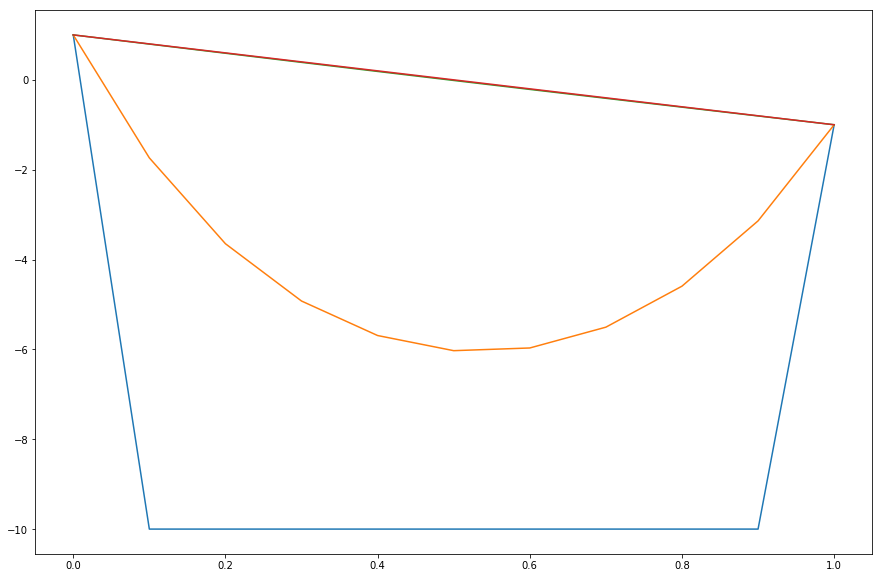

In [75]:

plt.figure()
slvr.plot([0, 1, 10, 100])

In [76]:
slvr.initialize(Cfix)

In [77]:
jaco = slvr.cf_grad(D+1, 0)

In [78]:
jaco

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [79]:
np.linalg.norm(jaco)

0.0

In [80]:
from scipy.optimize import minimize

In [81]:
result = np.zeros((11,101))
x = np.zeros((11,101)) + 0.1
for j in tqdm(range(1,101)):
    x0=x[:,j]
    res = minimize(fun=slvr.cost_function, x0=x0, jac=slvr.cf_grad,args=(j))
    result[:,j] = res['x']

#res = minimize(fun=slvr.cost_function, x0=x0, jac=slvr.cf_grad, method="Newton-CG")


  2%|█▋                                                                                | 2/100 [00:01<01:18,  1.26it/s]


KeyboardInterrupt: 

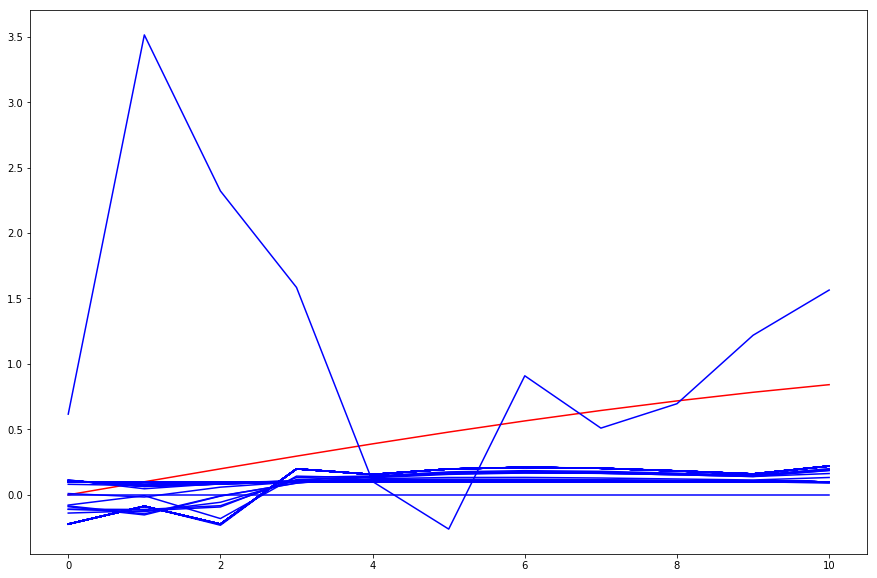

In [63]:
plt.figure()
plt.plot(D, 'r')
_ = plt.plot(result, 'b')
#plt.plot(x[:,100], 'g')

In [68]:
def GradientDescent(f, gradf, x0,  num_iter, ts, **kwargs):
    x_prev = x0.copy()
    
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
        
    i = 1
    less = False
    alpha =  0.01
    while True:
        
        gradient = gradf(x_prev, ts)
        ll = np.shape(gradient)
        x_new = np.zeros(ll[0])
        

        x_new = x_prev - alpha * gradient
        
        if (f(x_new, ts) - f(x_prev, ts)) < 0:
            x_prev = x_new
            iteration += 1
            #print("Current function val =", f(x_prev, ts))
            alpha =  0.01
            less = False
            
        else:
            less = True
            alpha *= 0.5
    
        if iteration >= num_iter:
            break
            
        
        #print("grad sign =", np.sign(gradf(x_prev) * gradf(x_new)))
        #print(f"x = {x}")
    res = {"x": x, "num_iter": iteration}
    return res

In [70]:
result = np.zeros((11,101))
x = np.zeros((11,101)) + 0.1
for j in tqdm(range(1,101)):
    x0=x[:,j]
    res = GradientDescent(f = slvr.cost_function, x0=x0, gradf=slvr.cf_grad, num_iter=20, ts=j)
    result[:,j] = res['x']

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 